In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter('ignore')


In [3]:
# データの読み込み
df_org = pd.read_csv('./data/ks-projects-201801.csv')


In [4]:
# 成功（successful）と失敗（failed）以外のデータを除外する
df = df_org[(df_org['state'] == 'successful') | (df_org['state'] == 'failed')]

## プロジェクトの状態（state）

In [57]:
state_mapping = { 'successful':1, 'failed':0}
df['state'] = df['state'].map(state_mapping)

## 日時

### 期間を新しく作成する
deadline - launched

In [58]:
# 日時に関する列を string から TimeStamp に変換
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

# 期間の列を作成
df['period'] = (df['deadline'] - df['launched']).dt.days # 差分を日数として表示

### launched
周期性を考慮してクォーターで分ける
米国の会計年度は10月から9月。

In [59]:
df['launched_year'] = df['launched'].dt.year
df['launched_month'] = df['launched'].dt.month
df['launched_day'] = df['launched'].dt.day

### 不要な列を削除する

In [60]:
# launched と deadline を削除
df = df.drop(columns=['deadline', 'launched'])

## カテゴリ

In [61]:
# main_categoryとcategoryを結合する（class）
df['class'] = df['main_category'].str.cat(df['category'], sep='**')
df.head()

,ID,name,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period,launched_year,launched_month,launched_day,class
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000.0,0.0,0,0,GB,0.0,0.0,1533.95,58,2015,8,11,Publishing**Poetry
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000.0,2421.0,0,15,US,100.0,2421.0,30000.00,59,2017,9,2,Film & Video**Narrative Film
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,45000.0,220.0,0,3,US,220.0,220.0,45000.00,44,2013,1,12,Film & Video**Narrative Film
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,1.0,0,1,US,1.0,1.0,5000.00,29,2012,3,17,Music**Music
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,50000.0,52375.0,1,224,US,52375.0,52375.0,50000.00,34,2016,2,26,Food**Restaurants


In [62]:
# 各classの個数をカウントし、dataframeに変換する
# https://www.web-dev-qa-db-ja.com/ja/python/python-pandas%EF%BC%9A-valuecounts%E5%87%BA%E5%8A%9B%E3%82%92%E3%83%87%E3%83%BC%E3%82%BF%E3%83%95%E3%83%AC%E3%83%BC%E3%83%A0%E3%81%AB%E5%A4%89%E6%8F%9B%E3%81%97%E3%81%BE%E3%81%99/835447736/
df_counts = df['class'].value_counts().rename_axis('class').reset_index(name='counts')
# トップ40位を抜き出す
df_largest = df_counts.nlargest(120, columns='counts')
# トップ40位の要素を削除したdataframeを作成する
df_others = df_counts.drop(df_largest.index)
# df_othersのclass列の項目をリスト化する
others_list = df_others['class'].to_list()
# others_list内の文字列に一致するclassをOthersに変更する
df = df.replace(others_list, 'Others')

In [63]:
df.head()

,ID,name,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period,launched_year,launched_month,launched_day,class
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000.0,0.0,0,0,GB,0.0,0.0,1533.95,58,2015,8,11,Publishing**Poetry
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000.0,2421.0,0,15,US,100.0,2421.0,30000.00,59,2017,9,2,Film & Video**Narrative Film
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,45000.0,220.0,0,3,US,220.0,220.0,45000.00,44,2013,1,12,Film & Video**Narrative Film
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,1.0,0,1,US,1.0,1.0,5000.00,29,2012,3,17,Music**Music
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,50000.0,52375.0,1,224,US,52375.0,52375.0,50000.00,34,2016,2,26,Food**Restaurants


## プロジェクト名
nameをどうにかする

### 単語数を抽出

In [64]:
# 単語数をカウントする関数
def count_words(sentence):
    words_list = str(sentence).split(' ') 
    return len(words_list)
# 単語数をカウントする関数を name の各データに適用
df['n_words'] = df['name'].apply(count_words) 
# name を削除
df = df.drop(columns=['name'])

## 目標金額
usd_goal_realを対数変換する

In [5]:
df['usd_goal_real'].head()

0     1533.95
1    30000.00
2    45000.00
3     5000.00
5    50000.00
Name: usd_goal_real, dtype: float64

<AxesSubplot:ylabel='Frequency'>

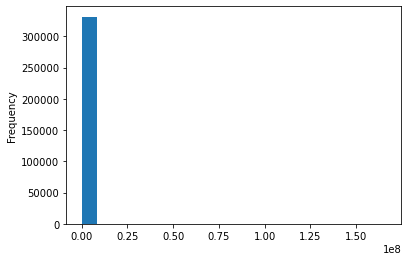

In [6]:
df['usd_goal_real'].plot(bins=20, kind='hist')

In [7]:
# usd_goal_realを対数変換する
df['log_goal'] = np.log(df['usd_goal_real'])
df = df.drop(columns='usd_goal_real')

<AxesSubplot:ylabel='Frequency'>

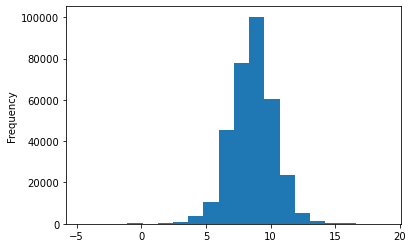

In [8]:
df['log_goal'].plot(bins=20, kind='hist')

# 加工データの保存

In [53]:
# df.to_csv('./data/input_01.csv')
# df.to_csv('./data/input_02.csv')
df.to_csv('./data/input_03.csv')

### input_01.csv
- 初期

### input_02.csv
- input_01
- main_category x category -> class

### input_03.csv
- input_01
- main_category x category -> class
- launched -> year/month/day

### input_04.csv・・・未作成（name除去だけなら3_学習でやればよい）
- input_03
- nameを除去